In [ ]:
!python -m spacy download en_core_web_sm

In [3]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import numpy as np

In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

## Data Preprocessing

In [3]:
df = pd.read_csv('suicide_detection.csv', index_col='Unnamed: 0')
df.head()

,text,class
2,Ex Wife Threatening SuicideRecently I left my ...,suicide
3,Am I weird I don't get affected by compliments...,non-suicide
4,Finally 2020 is almost over... So I can never ...,non-suicide
8,i need helpjust help me im crying so hard,suicide
9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


<AxesSubplot:xlabel='class', ylabel='count'>

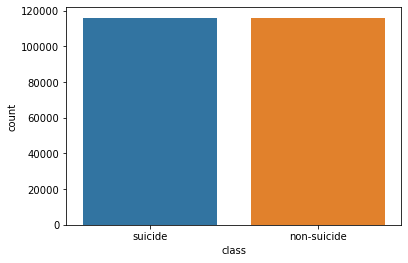

In [17]:
sns.countplot(data=df, x='class')

In [3]:
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

In [4]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x2450964e280>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x2450964edc0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x245096f2f00>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x245096d6c80>)]

In [102]:
def clean_text(text):
    text = text.lower()
    doc = nlp(text)
    
    text = ' '.join(token.lemma_ for token in nlp(text) if
              not token.is_punct
              and not token.is_currency
              and not token.is_digit
              and not token.is_punct
              and not token.is_space
#               and not token.is_stop
              and not token.like_num
#               and not token.pos_ == "PROPN"
                   )
    return text

In [105]:
df['text'] = df['text'].progress_apply(clean_text)

  0%|          | 0/232074 [00:00<?, ?it/s]

In [18]:
def count_token(text):
    try:
        return len(nlp(text))
    except:
        return 0

In [19]:
df['token_number'] = df['text'].progress_apply(count_token)

  0%|          | 0/232074 [00:00<?, ?it/s]

In [ ]:
df.to_csv('suicide_detection_cleaned.csv', index=False)

## Scope Data

In [ ]:
df = pd.read_csv('suicide_detection_cleaned.csv')

In [ ]:
use_df = df[(df['token_number']<=100) & (df['token_number']>0)]
print(f'df rows: {len(use_df)}')
print(f'percentage of new df: {len(use_df)/len(df)*100}')

In [10]:
df = df[(df['token_number']<=100) & (df['token_number']>0)]

<AxesSubplot:xlabel='token_number', ylabel='Count'>

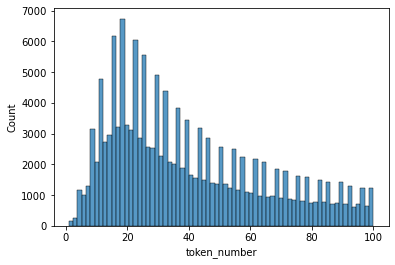

In [11]:
sns.histplot(df['token_number'])

In [24]:
df.head()

,text,class,token_number,tuples
1,be I weird I do not get affect by compliment i...,0,29,(be I weird I do not get affect by compliment ...
2,finally be almost over so I can never hear hav...,0,25,(finally be almost over so I can never hear ha...
3,I need helpjust help I I m cry so hard,1,10,"(I need helpjust help I I m cry so hard, 1)"
7,it end tonight.i can not do it anymore I quit,1,10,(it end tonight.i can not do it anymore I quit...
10,I take the rest of my sleeping pill and my pai...,1,33,(I take the rest of my sleeping pill and my pa...


## Data Formatting and Splitting

In [27]:
df['tuples'] = df.apply(lambda x: (x['text'], x['class']), axis=1)
data = df['tuples'].tolist()
data[:10]

[('be I weird I do not get affect by compliment if it be come from someone I know irl but I feel really good when internet stranger do it',
  0),
 ('finally be almost over so I can never hear have be a bad year ever again I swear to fucking god it be so annoying',
  0),
 ('I need helpjust help I I m cry so hard', 1),
 ('it end tonight.i can not do it anymore I quit', 1),
 ('I take the rest of my sleeping pill and my painkillersi can not wait for it to end I ’ve struggle for the past year and I ’m finally end it',
  1),
 ('can you imagine get old I neither.wrinkle weight gain hair loss mess up tooth and bone health issue menopause hormone hate new generation amp the way world progress be a useless angry piece of shit who can not take care of itself be totally depend on people who secretly want you to die already can you even imagine yourself there absolutely not even if I be happy I would take my life just to avoid this',
  1),
 ('do you think get hit by a train would be painful?gun be 

In [33]:
def load_data(data, limit=0, split=(0.7, 0.2, 0.1)):
    # Shuffle the data
    random.shuffle(data)
    texts, labels = zip(*data)

    # Splitting the training and evaluation data
    split_train = int(len(data) * split[0])
    split_val = int(len(data) * (split[0]+split[1]))
    return (texts[:split_train], labels[:split_train]), (texts[split_train:split_val], labels[split_train:split_val]), (texts[split_val:], labels[split_val:])

In [34]:
(train_texts, train_cats), (val_texts, val_cats), (test_texts, test_cats)  = load_data(data, limit=len(data))

In [41]:
train_data = list(zip(train_texts, train_cats))
val_data = list(zip(val_texts, val_cats))
test_data = list(zip(test_texts, test_cats))
train_data[:5]

[("question for people who have a jojo body pillow where do you get it I can not find normal jojo body pillow anywhere I 've be look for age",
  0),
 ('I be just a freshman but today I beat up a senior fuck you grandma', 0),
 ('m bored asf someone pm I kinda horny and kinda bored filler filler filler filler filler',
  0),
 ("I 'll make assumption about u base off ur comment history I 'll make assumption about u base off ur comment history filler filler filler filler filler filler filler",
  0),
 ('this be so wire I do not know what to think anymore why be I interested in guy on day and the next week I m interested in girl again like when will my mind make up it be mind do I need to test both',
  0)]

## Spacy Training

In [12]:
from spacy.tokens import DocBin

In [13]:
nlp = spacy.load('en_core_web_sm')

In [42]:
def make_docs(data):
    docs = []
    for doc, label in nlp.pipe(data, as_tuples=True):
        if label == 1:
            doc.cats['POSITIVE'] = 1
            doc.cats['NEGATIVE'] = 0
        else:
            doc.cats['POSITIVE'] = 0
            doc.cats['NEGATIVE'] = 1
        docs.append(doc)
    return docs

In [43]:
train_docs = make_docs(train_data)
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk('./data/train.spacy')

val_docs = make_docs(val_data)
doc_bin = DocBin(docs=val_docs)
doc_bin.to_disk('./data/val.spacy')

In [44]:
!python -m spacy init fill-config base_config.cfg config.cfg

[+] Auto-filled config with all values
[+] Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [47]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [48]:
!python -m spacy train config.cfg --output ./output --paths.train ./data/train.spacy --paths.dev ./data/val.spacy

[i] Saving to output directory: output
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['textcat']
[i] Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.12       24.25    0.24
  0     200         36.26       68.87    0.69
  0     400         12.03       84.12    0.84
  0     600          9.78       85.12    0.85
  0     800          3.21       86.35    0.86
  0    1000          1.99       87.74    0.88
  0    1200          0.87       87.61    0.88
  0    1400          0.60       88.98    0.89
  0    1600          0.31       89.43    0.89
  0    1800          0.22       89.59    0.90
  0    2000          0.13       90.03    0.90
  0    2200          0.08       89.95    0.90
  0    2400          0.05       90.28    0.90
  0    2600       

[2022-05-13 22:19:46,800] [INFO] Set up nlp object from config
[2022-05-13 22:19:46,807] [INFO] Pipeline: ['textcat']
[2022-05-13 22:19:46,809] [INFO] Created vocabulary
[2022-05-13 22:19:46,810] [INFO] Finished initializing nlp object
[2022-05-13 22:21:19,926] [INFO] Initialized pipeline components: ['textcat']


## Test Model

In [51]:
nlp = spacy.load('./output/model-best')

In [55]:
true_count = 0
for doc, label in nlp.pipe(test_data, as_tuples=True):
    if label == 1:
        if doc.cats['POSITIVE'] > 0.5:
            true_count += 1            
    else:
        if doc.cats['NEGATIVE'] > 0.5:
            true_count += 1    

print(f"Model's accuracy: {(true_count/len(test_data))*100}")

Model's accuracy: 93.46823594190928


In [56]:
doc = nlp('i want to kill myself')
doc.cats

{'POSITIVE': 0.9128209352493286, 'NEGATIVE': 0.08717909455299377}

In [57]:
doc = nlp('im just sad')
doc.cats

{'POSITIVE': 0.3176136910915375, 'NEGATIVE': 0.6823863387107849}